If you set all covariance matrices to σ2I (i.e., spherical) and drive σ2 to 0, this produces hard assignments. Therefore, when we run K-means,g it’s as if we’re doing GMM with EM but instead of letting each cluster have its own covariance matrix, they all have to be round covariance matrices and we make σ2 tiny so there’s no longer any notion of shared membership between clusters.
As a side note, K-means is sometimes used to initialize GMM/EM fitting

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import csv
import matplotlib
from  matplotlib import pyplot as plt
# from sklearn import cross_validation
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn import metrics, preprocessing
import pickle

In [4]:
df = pd.read_csv("data.csv")

In [5]:
df.head(5)

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


In [6]:
x = pd.Series(df['eruptions'])
y = pd.Series(df['waiting'])

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


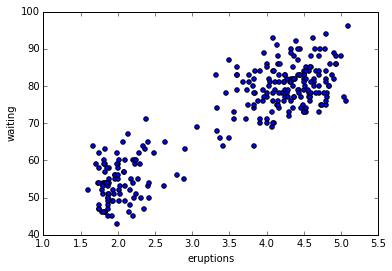

In [7]:
# pd.df.plot.scatter( x='eruptions', y='waiting')
df.plot(kind='scatter', x='eruptions', y='waiting')

In [7]:
# from sklearn.cross_validation import train_test_split
# train, test = train_test_split(df, test_size = 0.2)

In [38]:
# X = train.as_matrix()

In [39]:
# test = train.as_matrix()

In [8]:
X= df.as_matrix()

In [9]:
X[0:5]

array([[  3.6  ,  79.   ],
       [  1.8  ,  54.   ],
       [  3.333,  74.   ],
       [  2.283,  62.   ],
       [  4.533,  85.   ]])

In [69]:
# For code below: looks like I could get access to the coordinates and to the iterations in the below method
# https://gist.github.com/bistaumanga/6023716

In [24]:
class GMM:
    def __init__(self, k = 3, eps = 0.0001):
        self.k = k ## number of clusters
        self.eps = eps ## threshold to stop `epsilon`
        
        # All parameters from fitting/learning are kept in a named tuple
        from collections import namedtuple
    
    def fit_EM(self, X, max_iters = 1000):
        
        # n = number of data-points, d = dimension of data points        
        n, d = X.shape
        print("X.shape : " , n , d)
        
        # randomly choose the starting centroids/means 
        ## as n of the points from datasets   
        
        mu = X[np.random.choice(n, self.k, False), :]
        print("mu/ starting points: " , mu)
        
        # initialize the covariance matrices for each gaussians
        Sigma= [np.eye(d)] * self.k
        print("covariance matrics for each gaussian", Sigma)
        
        # initialize the probabilities/weights for each gaussians
        w = [1./self.k] * self.k
        print ("probability weights for each guassian", w)
        
        # responsibility matrix is initialized to all zeros
        # we have responsibility for each of n points for eack of k gaussians
        R = np.zeros((n, self.k))
        print ("responsibility matrix", R)
        
        ### log_likelihoods
        log_likelihoods = []
        
        P = lambda mu, s: np.linalg.det(s) ** -.5 ** (2 * np.pi) ** (-X.shape[1]/2.) \
                * np.exp(-.5 * np.einsum('ij, ij -> i',\
                        X - mu, np.dot(np.linalg.inv(s) , (X - mu).T).T ) ) 
                        
        # Iterate till max_iters iterations        
        while len(log_likelihoods) < max_iters:
            
            # E - Step
            
            ## Vectorized implementation of e-step equation to calculate the 
            ## membership for each of k -gaussians
            for k in range(self.k):
                R[:, k] = w[k] * P(mu[k], Sigma[k])
                print("R/ vectorized implementation of e-step equation", R)

            ### Likelihood computation
            log_likelihood = np.sum(np.log(np.sum(R, axis = 1)))
            print("log likelihood", log_likelihood)
            log_likelihoods.append(log_likelihood)
            
            
            ## Normalize so that the responsibility matrix is row stochastic
            R = (R.T / np.sum(R, axis = 1)).T
            
            ## The number of datapoints belonging to each gaussian            
            N_ks = np.sum(R, axis = 0)
            print ("num data points belonging to each guassian", N_ks)
            
            
            # M Step
            ## calculate the new mean and covariance for each gaussian by 
            ## utilizing the new responsibilities
            for k in range(self.k):
                
                ## means
                mu[k] = 1. / N_ks[k] * np.sum(R[:, k] * X.T, axis = 1).T
                x_mu = np.matrix(X - mu[k])
                print ("x_mu", x_mu)
                
                ## covariances
                Sigma[k] = np.array(1 / N_ks[k] * np.dot(np.multiply(x_mu.T,  R[:, k]), x_mu))
                
                ## and finally the probabilities
                w[k] = 1. / n * N_ks[k]
            # check for onvergence
            if len(log_likelihoods) < 2 : continue
            if np.abs(log_likelihood - log_likelihoods[-2]) < self.eps: break
        
        ## bind all results together
        from collections import namedtuple
        self.params = namedtuple('params', ['mu', 'Sigma', 'w', 'log_likelihoods', 'num_iters'])
        self.params.mu = mu
        self.params.Sigma = Sigma
        self.params.w = w
        self.params.log_likelihoods = log_likelihoods
        self.params.num_iters = len(log_likelihoods)       
        
        print("self.params, " , self.params)
        return self.params
    
    def plot_log_likelihood(self):
        import pylab as plt
        plt.plot(self.params.log_likelihoods)
        plt.title('Log Likelihood vs iteration plot')
        plt.xlabel('Iterations')
        plt.ylabel('log likelihood')
        plt.show()
    
    def predict(self, x):
        p = lambda mu, s : np.linalg.det(s) ** - 0.5 * (2 * np.pi) **\
                (-len(x)/2) * np.exp( -0.5 * np.dot(x - mu , \
                        np.dot(np.linalg.inv(s) , x - mu)))
        probs = np.array([w * p(mu, s) for mu, s, w in \
            zip(self.params.mu, self.params.Sigma, self.params.w)])
        return probs/np.sum(probs)

In [25]:
gmm = GMM(2, 0.0001 )

In [26]:
gmm_fitted = gmm.fit_EM(X, max_iters = 1000)

X.shape :  272 2
mu/ starting points:  [[  3.817  80.   ]
 [  2.     58.   ]]
covariance matrics for each gaussian [array([[ 1.,  0.],
       [ 0.,  1.]]), array([[ 1.,  0.],
       [ 0.,  1.]])]
probability weights for each guassian [0.5, 0.5]
responsibility matrix [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  

In [27]:
print (gmm_fitted.log_likelihoods)
import pylab as plt    
from matplotlib.patches import Ellipse

[-5172.9580853593952, -815.64116641510225, -785.23448849534486, -775.2962795401852, -774.22727247507896, -774.22557524428419, -774.23370056091039, -774.23543867295075, -774.23576688120727, -774.23582773232386]


In [28]:
def plot_ellipse(pos, cov, nstd=2, ax=None, **kwargs):
        def eigsorted(cov):
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            return vals[order], vecs[:,order]
    
        if ax is None:
            ax = plt.gca()
    
        vals, vecs = eigsorted(cov)
        theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
        # Width and height are "full" widths, not radius
        width, height = 2 * nstd * np.sqrt(abs(vals))
        ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    
        ax.add_artist(ellip)
        return ellip

In [29]:
def show(X, mu, cov):

    plt.cla()
    K = len(mu) # number of clusters
    colors = ['b', 'k', 'g', 'c', 'm', 'y', 'r']
    plt.plot(X.T[0], X.T[1], 'm*')
    for k in range(K):
        plot_ellipse(mu[k], cov[k],  alpha=0.6, color = colors[k % len(colors)])  




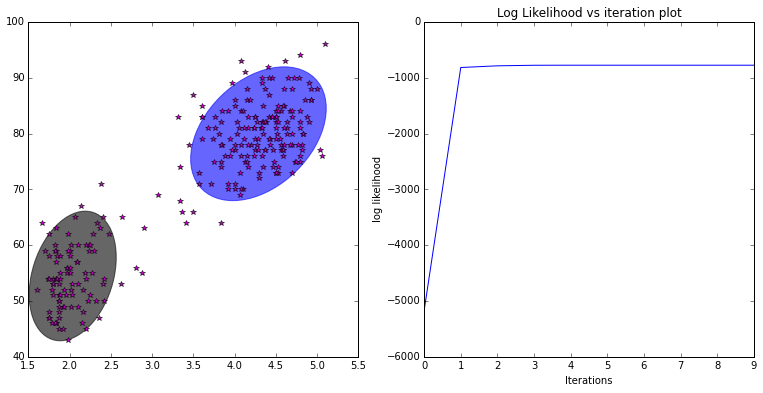

In [30]:
fig = plt.figure(figsize = (13, 6))
fig.add_subplot(121)
show(X, gmm_fitted.mu, gmm_fitted.Sigma)
fig.add_subplot(122)
plt.plot(np.array(gmm_fitted.log_likelihoods))
plt.title('Log Likelihood vs iteration plot')
plt.xlabel('Iterations')
plt.ylabel('log likelihood')
plt.show()
# print gmm.predict(np.array([1, 2]))

In [1]:
np.eye(2)

NameError: name 'np' is not defined

In [15]:
Sigma= [np.eye(2)]*2

In [16]:
Sigma

[array([[ 1.,  0.],
        [ 0.,  1.]]), array([[ 1.,  0.],
        [ 0.,  1.]])]

In [17]:
 w = [1./2] * 2

In [18]:
w

[0.5, 0.5]